In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
# import ppscore as pps # ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

from xgboost import XGBRegressor
from sklearn_evaluation import plot

from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.utils import return_significative_coef

%load_ext autoreload
%autoreload 2

# Prepare data

## Obtain data for WGs

In [2]:
df_original = get_processed_ads_table()


===> Loaded all_encoded.csv locally
===> ads_OSM.csv saved locally


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27691 entries, 0 to 27701
Columns: 146 entries, id to cos_day_week_int
dtypes: Float64(2), Int64(1), datetime64[ns](3), float64(117), int64(5), object(18)
memory usage: 31.1+ MB


In [4]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin'])]#, 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

## Remove duplicates if exist

In [5]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [6]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']=='WG']
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered.describe()

,commercial_landlord,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,male_flatmates,female_flatmates,diverse_flatmates,published_at,latitude,longitude,details_searched,cold_rent_euros,mandatory_costs_euros,extra_costs_euros,transfer_costs_euros,deposit,zip_code,wg_possible,building_floor,public_transport_distance,home_total_size,schufa_needed,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,construction_year,energy_usage,energy_efficiency_class,price_per_sqm_warm,price_per_sqm_cold,number_languages,internet_speed,toilet,internet_dsl,internet_wlan,internet_flatrate,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,tv_kabel,tv_satellit,days_available,furniture_numerical,kitchen_numerical,smoking_numerical,room_size_house_fraction,flat_with_kids,km_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,activities_public_service,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,comfort_green_forests,mobility_street_primary,comfort_lakes,activities_health_regional,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,sin_degrees_to_centroid,cos_degrees_to_centroid,sin_published_at,cos_published_at,sin_day_week_int,cos_day_week_int
count,8338.000000,8338.000000,8338.000000,8338.0,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,6680.000000,8338.000000,8338.000000,8338.0,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8325.000000,8338.0,7436.000000,7343.000000,5756.000000,8338.000000,6283.000000,5883.000000,8338.000000,8338.000000,930.000000,291.000000,424.000000,8338.000000,8338.000000,8338.000000,2511.000000,17.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,5756.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.0,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.0,8338.000000,8338.000000,8338.0,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,6.680000e+03,6680.000000,8338.000000,8338.000000
mean,0.008036,480.386424,17.299472,1.0,3.269009,1.257616,0.959822,1.034541,0.017030,14.952096,50.925245,10.203634,1.0,386.365795,58.800792,6.780403,30.572679,568.744903,44983.665225,1.0,1.991393,3.199510,92.147846,0.084793,24.399809,29.946626,13.6

## Drop columns I won't use for modelling

In [7]:
# Drop unnecessary columns
df_filtered = df_filtered[[
#         'url',
        'commercial_landlord',
#         'title',
#         'type_offer_simple',
#         'size_sqm',
        'home_total_size',
        'room_size_house_fraction',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',
    
#         'address',
        'city',
#         'zip_code',
#         'latitude',
#         'longitude',
    
#         'published_on',
#         'published_at',
#         'day_of_week_publication',
#         'available_from',
#         'available_to',
#         'days_available',
        'rental_length_term', # use rental length period cause relationship isnt linear. Correlates for first 30 days only
#         'sin_published_at',
#         'cos_published_at',
#         'sin_day_week_int',
#         'cos_day_week_int',
    
#         'details_searched',
#         'crawler',
    
# Values
#         'price_euros',    
#         'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
        'transfer_costs_euros',
#         'price_per_sqm_warm',
        'price_per_sqm_cold',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
        'min_age_flatmates',
        'max_age_flatmates',
        'flat_with_kids',
    
# Person searched
        'gender_searched',
        'min_age_searched',
        'max_age_searched',
#         'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'smoking_numerical',
        'building_type',
        'building_floor',
#         'furniture',
        'furniture_numerical',
#         'kitchen',
        'kitchen_numerical',
        'heating',
        'public_transport_distance',
        'parking',
    
#         'construction_year',
#         'energy_certificate',
#         'energy_usage',
#         'energy_efficiency_class',
#         'heating_energy_source',
    
        'tv_kabel',
        'tv_satellit',
    
#         'toilet',
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
        'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'number_languages',
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_speed',
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate',
    

# Geographical
        'km_to_centroid',
        'sin_degrees_to_centroid',
        'cos_degrees_to_centroid',

# OSM features
        'comfort_leisure_spots',
        'comfort_warehouse',
        'activities_education',
        'mobility_public_transport_bus',
        'activities_economic',
        'comfort_industrial',
        'activities_goverment',
        'social_life_eating',
        'comfort_comfort_spots',
        'social_life_culture',
        'activities_supermarket',
#         'activities_public_service',
        'social_life_community',
        'comfort_leisure_mass',
        'activities_educational',
        'mobility_street_secondary',
        'mobility_public_transport_rail',
        'activities_retail',
        'social_life_night_life',
        'comfort_green_natural',
        'comfort_railway',
        'mobility_bike_infraestructure',
#         'comfort_green_forests',
        'mobility_street_primary',
        'comfort_lakes',
#         'activities_health_regional',
        'activities_health_local',
        'comfort_green_space',
        'comfort_rivers',
        'activities_post',
        'comfort_green_parks',
        'comfort_street_motorway'
        ]]

## Define numerical and categorical columns

In [8]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df_filtered)
categorical_columns = categorical_columns_selector(df_filtered)
# categorical_columns.remove('city')

# Removing outliers

In [9]:
### List of columns with manually inserted values that would possibly contain outliers and/werid values

manually_inserted_values_columns = [
#     'price_euros',
#     'size_sqm',
#     'cold_rent_euros',
#     'price_per_sqm_warm',
    'price_per_sqm_cold',
#     'mandatory_costs_euros',
#     'extra_costs_euros',
#     'deposit',
    'home_total_size',
    'room_size_house_fraction',
    'public_transport_distance',
    'transfer_costs_euros',
    'min_age_flatmates',
    'max_age_flatmates',
    'min_age_searched',
    'max_age_searched',
#     'construction_year',
#     'energy_usage'
]

'room_size_house_fraction'

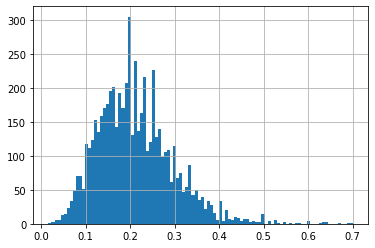

In [10]:
### Manually look into the variable distribution to identify outliers
col = manually_inserted_values_columns[2]
df_filtered[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,1000)
# plt.ylim(0,100);
col

In [11]:
df_filtered.describe()

,commercial_landlord,home_total_size,room_size_house_fraction,capacity,transfer_costs_euros,price_per_sqm_cold,male_flatmates,female_flatmates,diverse_flatmates,min_age_flatmates,max_age_flatmates,flat_with_kids,min_age_searched,max_age_searched,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,public_transport_distance,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,number_languages,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_speed,internet_dsl,internet_wlan,internet_flatrate,km_to_centroid,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway
count,8338.000000,5756.000000,5756.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,6283.000000,5883.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,7436.000000,8338.000000,8338.000000,7343.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,2511.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000
mean,0.008036,92.147846,0.211948,3.269009,30.572679,23.619916,0.959822,1.034541,0.017030,24.399809,29.946626,0.010794,13.634685,58.745503,0.084793,0.19675,1.991393,0.529563,0.003448,3.199510,0.174262,0.050012,0.264332,0.308707,0.149916,0.215759,0.283281,0.055889,0.192612,0.069081,0.032262,0.739146,0.545095,0.106380,0.423723,0.258335,0.182058,0.463181,0.110818,0.07160,0.320221,0.000120,2.093068,0.843008,0.720676,0.483929,0.410890,0.011274,0.023387,0.005757,0.048693,0.003718,0.013792,0.35692,0.385824,0.007316,0.005397,0.103982,0.001679,0.008515,0.027105,5.843489,0.369393,0.713480,0.208323,3.615179,0.025675,-0.106999,0.074528,0.109631,0.016948,0.274676,0.154729,0.868898,1.043571e-03,0.817450,1.111644,0.031916,1.151072e-02,0.052647,0.017358,0.090932,2.494014,0.209103,1.810365,0.248342,0.305862,0.704398,1.140561,1.310392,0.997330,0.224214,1.406366,0.062168,0.163193,1.989533,0.022060
std,0.089285,43.477566,0.084592,1.584818,131.711537,9.492894,1.011837,1.127

# Dealing with NAs

In [12]:
df_imputted = df_filtered.copy()

In [13]:
# Percentage missing values per column before imputting
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

internet_speed               69.884864
room_size_house_fraction     30.966659
home_total_size              30.966659
max_age_flatmates            29.443512
min_age_flatmates            24.646198
public_transport_distance    11.933317
building_floor               10.817942
km_to_centroid                0.000000
internet_wlan                 0.000000
internet_flatrate             0.000000
dtype: float64

## Imputting numerical columns

'home_total_size'

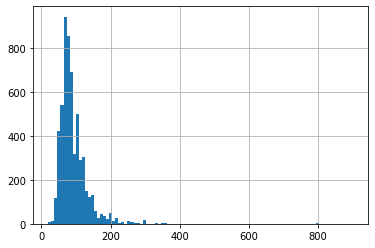

In [14]:
num_cols_imputing = ['internet_speed',
                     'max_age_flatmates','min_age_flatmates',
                     'home_total_size',
                     'room_size_house_fraction',
#                     'cos_published_at', 'sin_published_at',
                    'public_transport_distance','building_floor']

col = num_cols_imputing[3]
df_imputted[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,300)
# plt.ylim(0,100);
col

In [15]:
num_cols_imputing_mean = ['min_age_flatmates', 'max_age_flatmates','home_total_size','room_size_house_fraction']
num_cols_imputing_median = ['internet_speed', 'public_transport_distance', 'building_floor','flat_with_kids'] 

num_imputer_mean = SimpleImputer(strategy="mean") # Instantiate a SimpleImputer object with your strategy of choice
num_imputer_median = SimpleImputer(strategy="median") # Instantiate a SimpleImputer object with your strategy of choice

num_imputer_mean.fit(df_imputted[num_cols_imputing_mean]) # Call the "fit" method on the object
num_imputer_median.fit(df_imputted[num_cols_imputing_median]) # Call the "fit" method on the object

df_imputted[num_cols_imputing_mean] = num_imputer_mean.transform(df_imputted[num_cols_imputing_mean]) # Call the "transform" method on the object
df_imputted[num_cols_imputing_median] = num_imputer_median.transform(df_imputted[num_cols_imputing_median]) # Call the "transform" method on the object

num_imputer_mean.statistics_,  num_imputer_median.statistics_# The mean is stored in the transformer's memory

(array([24.39980901, 29.94662587, 92.14784573,  0.21194842]),
 array([6., 3., 2., 0.]))

In [16]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

commercial_landlord        0.0
wg_type_inklusive          0.0
comfort_warehouse          0.0
comfort_leisure_spots      0.0
cos_degrees_to_centroid    0.0
sin_degrees_to_centroid    0.0
km_to_centroid             0.0
internet_flatrate          0.0
internet_wlan              0.0
internet_dsl               0.0
dtype: float64

## Imputting categorical columns

In [17]:
# For some unknown reason imputting for transfer_costs_euros doesn't work, so I manually imput 0 values here for transfer_costs_euros without a answer
features_noanswer = ['transfer_costs_euros']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value=0) 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [18]:
# Features in which NaN values represent something
features_noanswer = ['heating', 'parking', 'building_type']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value="no_answer") 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [19]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

commercial_landlord        0.0
wg_type_inklusive          0.0
comfort_warehouse          0.0
comfort_leisure_spots      0.0
cos_degrees_to_centroid    0.0
sin_degrees_to_centroid    0.0
km_to_centroid             0.0
internet_flatrate          0.0
internet_wlan              0.0
internet_dsl               0.0
dtype: float64

# Scaling columns

In [20]:
df_scaled = df_imputted.copy()

## Find colums for each type of scaling

In [21]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial',
                'activities_goverment',
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
                'activities_supermarket',
#                 'activities_public_service',
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary',
                'mobility_public_transport_rail',
                'activities_retail',
                'social_life_night_life',
                'comfort_green_natural',
                'comfort_railway',
                'mobility_bike_infraestructure',
#                 'comfort_green_forests',
                'mobility_street_primary',
                'comfort_lakes',
#                 'activities_health_regional',
                'activities_health_local',
                'comfort_green_space',
                'comfort_rivers',
                'activities_post',
                'comfort_green_parks',
                'comfort_street_motorway']

In [22]:
continuous_num_cols = [#'size_sqm',
                       'public_transport_distance',
                       'km_to_centroid'] + features_OSM

In [23]:
# for numerical_feature in continuous_num_cols:
#     fig, ax = plt.subplots(1,3, figsize = (15,5))
    
#     ax[0].set_title(f"Distribution of {numerical_feature}")
#     sns.histplot(x = df_scaled[numerical_feature], kde = True, ax = ax[0])
    
#     ax[1].set_title(f"Boxplot of {numerical_feature}")
#     sns.boxplot(x = df_scaled[numerical_feature], ax = ax[1])
    
#     ax[2].set_title(f"QQplot of {numerical_feature}")
#     qqplot(df_scaled[numerical_feature], line='s', ax = ax[2])

['public_transport_distance', 'km_to_centroid', 'comfort_leisure_spots']


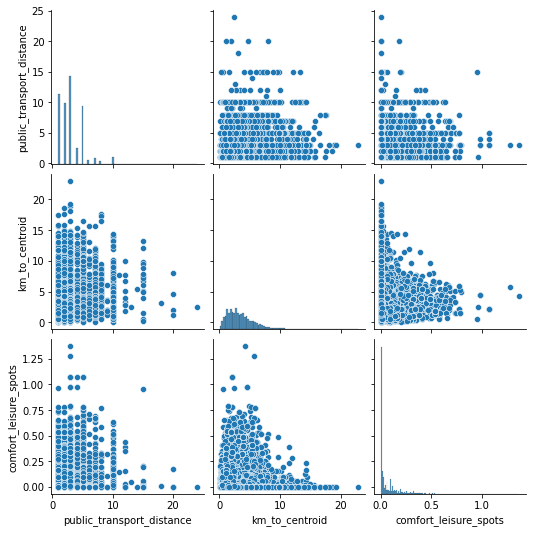

In [24]:
cols = continuous_num_cols[0:3]#numerical_columns[0:3]
sns.pairplot(df_scaled.reset_index(), vars=cols);
print(cols)

In [25]:
cols_minmax_scaler = ['capacity', 'transfer_costs_euros', 
#                       'days_available',
                      'public_transport_distance',
                      'male_flatmates', 'female_flatmates', 'diverse_flatmates',
                      'min_age_flatmates', 'max_age_flatmates', 'min_age_searched', 'max_age_searched',
                      'smoking_numerical', 'building_floor', 'furniture_numerical', 'kitchen_numerical',
                      'number_languages', 'internet_speed', 'sin_degrees_to_centroid', 'cos_degrees_to_centroid'] + features_OSM
cols_standard_scaler = [#'size_sqm', 
                        'km_to_centroid']
cols_robust_scaler = ['home_total_size','room_size_house_fraction']

## Scaling features

In [26]:
# Instanciate MinMaxScaler
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Fit scaler to data
minmax_scaler.fit(df_scaled[cols_minmax_scaler])
standard_scaler.fit(df_scaled[cols_standard_scaler])
robust_scaler.fit(df_scaled[cols_robust_scaler])

# Use scaler to transform data
df_scaled[cols_minmax_scaler] = minmax_scaler.transform(df_scaled[cols_minmax_scaler])
df_scaled[cols_standard_scaler] = standard_scaler.transform(df_scaled[cols_standard_scaler])
df_scaled[cols_robust_scaler] = robust_scaler.transform(df_scaled[cols_robust_scaler])

In [27]:
df_scaled.describe()

,commercial_landlord,home_total_size,room_size_house_fraction,capacity,transfer_costs_euros,price_per_sqm_cold,male_flatmates,female_flatmates,diverse_flatmates,min_age_flatmates,max_age_flatmates,flat_with_kids,min_age_searched,max_age_searched,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,public_transport_distance,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,number_languages,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_speed,internet_dsl,internet_wlan,internet_flatrate,km_to_centroid,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway
count,8338.000000,8.338000e+03,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000
mean,0.008036,-1.082261e-16,2.426566e-16,0.084601,0.010727,23.619916,0.106647,0.064659,0.001064,0.116360,0.192688,0.010794,0.257258,0.503031,0.084793,0.19675,0.427475,0.529563,0.003448,0.094596,0.174262,0.050012,0.264332,0.308707,0.149916,0.215759,0.283281,0.055889,0.192612,0.069081,0.032262,0.739146,0.545095,0.106380,0.423723,0.258335,0.182058,0.463181,0.110818,0.07160,0.320221,0.000120,0.039038,0.843008,0.720676,0.483929,0.410890,0.011274,0.023387,0.005757,0.048693,0.003718,0.013792,0.35692,0.385824,0.007316,0.005397,0.103982,0.001679,0.008515,0.027105,0.825478,0.369393,0.713480,0.208323,5.113044e-18,0.512837,0.446501,0.054379,0.017067,0.035551,0.125956,0.085541,0.032578,2.049046e-02,0.124913,0.036443,0.069915,1.467775e-02,0.118375,0.071591,0.098544,0.126494,0.132448,0.048397,0.060989,0.011900,0.028468,0.043868,0.101724,0.033591,0.068474,0.023649,0.025375,0.194231,0.032945,0.007269
std,0.089285,1.720140e+00,1.286010e+00,0.105655,0.046215,9.492894,

# OneHot encoding

In [28]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', categories='auto')
feature_arr = ohe.fit_transform(df_filtered[categorical_columns])

## Get name of new columns and create new dataframe
feature_labels = ohe.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)

In [29]:
# Give correct indexes to feature table. Needed for concatenating
features.index = df_filtered.index
## Add new columns to dataframe
df_processed = pd.concat([df_scaled, features], axis = 1).drop(columns=categorical_columns)
df_processed.columns = [col.lower().replace(' ', '_').replace('ä','ae').replace('ö','oe').replace('ü','ue').replace('ß','ss') for col in df_processed.columns]

In [30]:
df_processed.shape

(8338, 155)

# Minimize features

In [31]:
df_minimal = df_processed.copy()

In [32]:
df_minimal.shape

(8338, 155)

In [33]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in ['price_per_sqm_cold', 'commercial_landlord']]
cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.99:
        cols_exclude.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude)
df_minimal.shape

(8338, 142)

In [34]:
cols_exclude

['kitchen_numerical',
 'extras_dachboden',
 'wg_type_wohnheim',
 'wg_type_alleinerziehende',
 'wg_type_mit_kindern',
 'wg_type_verbindung',
 'wg_type_senioren',
 'wg_type_inklusive',
 'gender_searched_divers',
 'building_type_plattenbau',
 'heating_kohleofen',
 'heating_nachtspeicherofen',
 'heating_ofenheizung']

# Colinearity

In [35]:
df_analysed = df_minimal.copy()

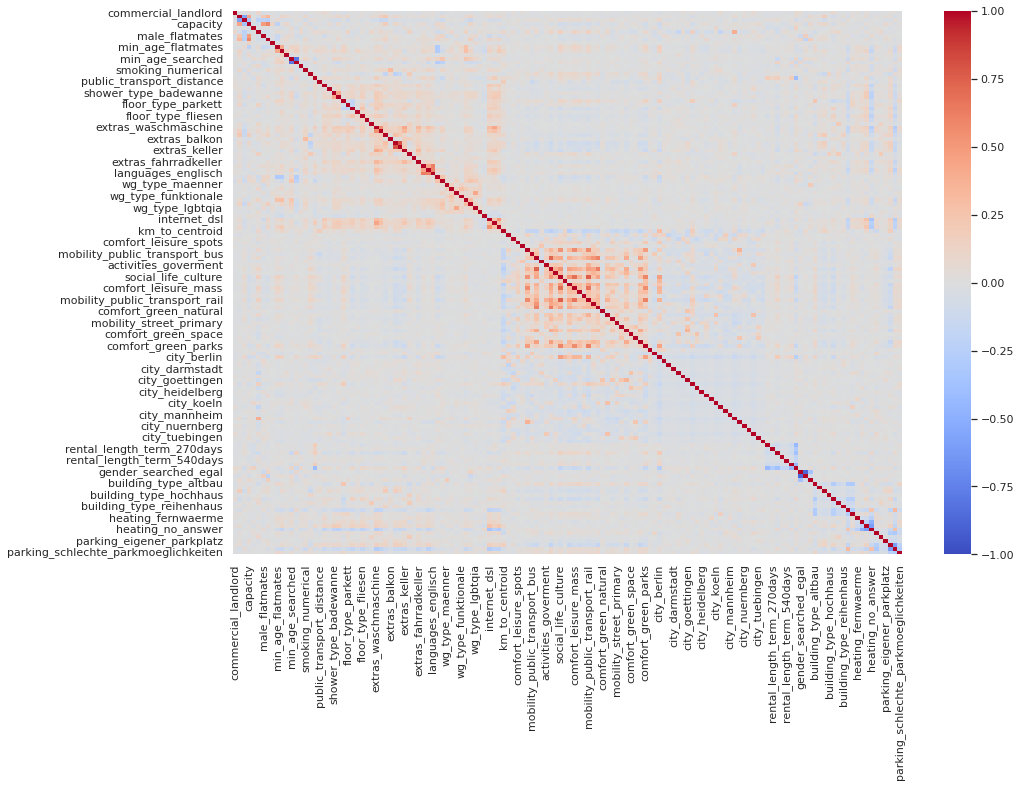

In [36]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [37]:
df_analysed = df_analysed.drop(columns=[#'age_category_searched_20_100',
                                        'parking_schlechte_parkmoeglichkeiten',
                                        'rental_length_term_plus540days',
                                        'internet_speed',
                                        #'extras_gartenmitbenutzung',
                                        'gender_searched_egal'
                                       ])

In [38]:
data_corr = df_analysed.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

,feature_1,feature_2,correlation
4864,extras_gartenmitbenutzung,extras_garten,0.799384
4727,extras_garten,extras_gartenmitbenutzung,0.799384
9458,social_life_culture,mobility_public_transport_rail,0.759729
10280,mobility_public_transport_rail,social_life_culture,0.759729
9171,social_life_eating,activities_economic,0.726809
8760,activities_economic,social_life_eating,0.726809
9866,comfort_leisure_mass,social_life_culture,0.682304
9455,social_life_culture,comfort_leisure_mass,0.682304
9872,comfort_leisure_mass,mobility_public_transport_rail,0.666205
10283,mobility_public_transport_rail,comfort_leisure_mass,0.666205


In [39]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
# df_analysed = df_analysed.drop(columns = ['internet_speed',
#                     'max_age_searched',
# #                     'rental_length_term_plus540days',
#                     'days_available',
#                     'min_age_flatmates',
#                     'min_age_searched'
#                   ])

In [40]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
cols_to_exclude = []
while remove:
    df = pd.DataFrame()
    
    selected_columns = ['price_per_sqm_cold'] # Ignore the targer column
    selected_columns = [col for col in df_analysed.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude = cols_to_exclude + df.features.to_list()
        df_analysed = df_analysed.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude

       features  vif_index
88  city_berlin      74.64
              features  vif_index
130  heating_no_answer      47.66
                 features  vif_index
118  building_type_altbau      17.86
             features  vif_index
40  languages_deutsch      11.37


['city_berlin',
 'heating_no_answer',
 'building_type_altbau',
 'languages_deutsch']

In [41]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_analysed.columns.to_list() if col not in ['price_per_sqm_cold']]

df["features"] = selected_columns

df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

,features,vif_index
11,min_age_searched,8.31
29,extras_waschmaschine,7.89
12,max_age_searched,7.69
72,mobility_public_transport_rail,7.56
9,max_age_flatmates,6.76
15,building_floor,6.72
40,languages_englisch,6.26
64,social_life_eating,5.78
66,social_life_culture,5.60
3,capacity,5.58


In [42]:
df_analysed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8338 entries, 9605533 to 8171482
Columns: 134 entries, commercial_landlord to parking_no_answer
dtypes: float64(134)
memory usage: 8.6 MB


# Feature permutation

In [43]:
df_permuted = df_analysed.copy()

## Permutation analysis

In [44]:
X = df_permuted.drop(columns=['price_per_sqm_cold'])
y = df_permuted['price_per_sqm_cold']

model = Ridge().fit(X, y) # Fit model

In [45]:
permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [46]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 score decrease','r2 score decrease std',
                       'RMSE score increase','RMSE score increase std']

In [47]:
importance_df = importance_df.sort_values(by="r2 score decrease", ascending = False) # Order by importance
importance_df[:50]

,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
2,room_size_house_fraction,0.331892,0.007636,1.933891,0.039545
1,home_total_size,0.156752,0.004603,0.973841,0.026794
102,city_muenchen,0.133295,0.003841,0.836059,0.022771
99,city_leipzig,0.125648,0.003949,0.790596,0.023552
90,city_dresden,0.088406,0.003513,0.565156,0.021592
96,city_karlsruhe,0.043488,0.002274,0.283673,0.014535
94,city_hannover,0.042164,0.002452,0.275202,0.015694
111,rental_length_term_30days,0.04157,0.002078,0.271404,0.013303
92,city_goettingen,0.041282,0.002255,0.269558,0.014435
103,city_muenster,0.036016,0.002035,0.235752,0.013099


In [48]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

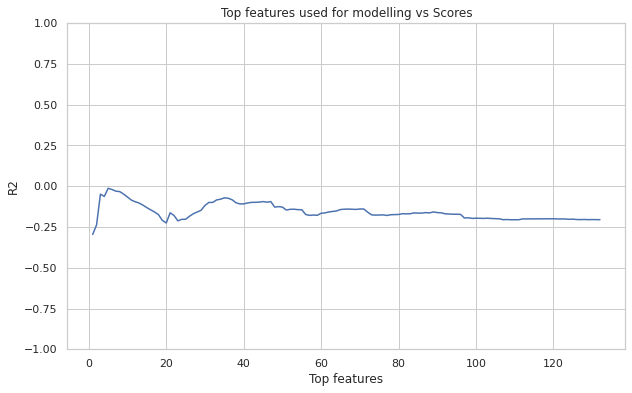

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [52]:
importance_df_selected = importance_df[importance_df['r2 score decrease']>= 0.001]
columns_excluded = importance_df[importance_df['r2 score decrease']< 0.001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

(58, 5)


,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
2,room_size_house_fraction,0.331892,0.007636,1.933891,0.039545
1,home_total_size,0.156752,0.004603,0.973841,0.026794
102,city_muenchen,0.133295,0.003841,0.836059,0.022771
99,city_leipzig,0.125648,0.003949,0.790596,0.023552
90,city_dresden,0.088406,0.003513,0.565156,0.021592
96,city_karlsruhe,0.043488,0.002274,0.283673,0.014535
94,city_hannover,0.042164,0.002452,0.275202,0.015694
111,rental_length_term_30days,0.04157,0.002078,0.271404,0.013303
92,city_goettingen,0.041282,0.002255,0.269558,0.014435
103,city_muenster,0.036016,0.002035,0.235752,0.013099


In [51]:
important_features = importance_df_selected.feature.to_list()

In [56]:
columns_excluded

,feature,r2 score decrease,r2 score decrease std,RMSE score increase,RMSE score increase std
31,extras_terrasse,0.000984,0.000376,0.006552,0.002504
73,activities_retail,0.000981,0.000367,0.006532,0.002443
60,mobility_public_transport_bus,0.00098,0.000376,0.006523,0.002501
38,extras_fahrradkeller,0.000964,0.000339,0.006418,0.002258
25,floor_type_teppich,0.000941,0.00033,0.006264,0.002194
...,...,...,...,...,...
17,public_transport_distance,0.000001,0.000008,0.000009,0.000054
83,activities_post,0.000001,0.000009,0.000005,0.000058
112,rental_length_term_365days,0.0,0.000018,0.000003,0.000122
10,flat_with_kids,0.0,0.000001,0.000001,0.000009


# Predictive Power Score

In [ ]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

In [ ]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [ ]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [ ]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

#  Model parametrization and Learning curves

In [ ]:
X = df_analysed.drop(columns=['price_per_sqm_cold'])
X = df_analysed[important_features]
y = df_analysed['price_per_sqm_cold']

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Linear Regression

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(n_jobs=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Ridge linear Regression

In [ ]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr','auto']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
report_best_scores(ridge_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(ridge_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = ridge_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Lasso linear Regression

In [ ]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [0.1,1,10,100],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
report_best_scores(lasso_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(lasso_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = lasso_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## ElasticNet linear Regression

In [ ]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.001,0.01,0.1,1],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
report_best_scores(elastic_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(elastic_rsearch.cv_results_, change="alpha", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = elastic_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Stochastic Gradient Descend

In [ ]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error','epsilon_insensitive', 'squared_epsilon_insensitive'],#, 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.0001, 0.001,0.01],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [10],#[1,10,100],
    'l1_ratio': [1],#[0,0.3,0.6,1],
    'epsilon': [1,10,100],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.001,0.01,0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
report_best_scores(sgdr_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(sgdr_rsearch.cv_results_, change="loss", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = sgdr_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## KNN Regressor

In [ ]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': range(20,50,1),
    'weights': ['distance'],#['uniform', 'distance'],
    'algorithm': ['brute'],#['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [2]#range(2,15,1)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
report_best_scores(knn_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(knn_rsearch.cv_results_, change="leaf_size", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = knn_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Support Vector Machine

In [ ]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['poly'],#['linear','poly','sigmoid', 'rbf'],
    'degree': range(2,5,1),
    'C': [10,100,1000],
    'tol': [0.001],#[0.001,0.01,0.1],
    'gamma': ['auto'],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [1],#[0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
report_best_scores(svm_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(svm_rsearch.cv_results_, change="degree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = svm_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Decision Tree Regressor

In [ ]:
%%time
# Instanciate model
model = DecisionTreeRegressor()

# Hyperparameter search space
search_space = {
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(14,17,1),
    'min_samples_leaf': range(2,5,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [0.8],#[0.6,0.7,0.8,0.9],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.3],#[0.2,0.3,0.4,0.5],
    'ccp_alpha':[0.0],#[0.2,0.25,0.3,0.35],
}

# Instanciate GridSearchCV
tree_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


tree_rsearch.fit(X,y)
report_best_scores(tree_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(tree_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = tree_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Random Forest Regressor

In [ ]:
%%time
# Instanciate model
model = RandomForestRegressor()

# Hyperparameter search space
search_space = {
    'n_jobs':[-1],
    'n_estimators': [100],#[100,200,500,1000],
    'criterion': ['squared_error'],#['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': range(2,5,1),
    'min_samples_split': range(6,8,1),
    'min_samples_leaf': range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [1.0],#[0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1), #int, default=None
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'bootstrap':[False],#[True, False]
    'ccp_alpha':[0.0],
}

# Instanciate GridSearchCV
rand_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


rand_rsearch.fit(X,y)
report_best_scores(rand_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(rand_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = rand_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Gradient Boosting Regressor

In [ ]:
%%time
# Instanciate model
model = GradientBoostingRegressor()

# Hyperparameter search space
search_space = {
    'learning_rate': [0.1],#[0.001,0.01,0.1],
    'n_estimators': [100],#[100,200,500,1000],
    'loss': ['squared_error'],#['squared_error', 'absolute_error', 'huber', 'quantile'],
    'subsample':[0.66],#[0.33,0.66,1.0],
    'criterion': ['friedman_mse'],#['squared_error', 'friedman_mse'],
    'min_samples_split': [7],#range(6,8,1),
    'min_samples_leaf': [3],#range(2,4,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_depth': range(2,4,1),
    'min_impurity_decrease': [0.4],#[0.3,0.4,0.5],
    'max_features': [0.7,0.8,0.9,1.0],
    'max_leaf_nodes': [4],#range(3,5,1),
    'ccp_alpha':[0.3],#[0.25,0.3,0.35],
}

# Instanciate GridSearchCV
gradboos_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


gradboos_rsearch.fit(X,y)
report_best_scores(gradboos_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(gradboos_rsearch.cv_results_, change="max_depth", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = gradboos_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Extreme Gradient Boosting (XGB) Regressor

In [ ]:
%%time
# Instanciate model
model = XGBRegressor()

# Hyperparameter search space
search_space = {
    "colsample_bytree": [0.6,0.7,0.8],
#     "gamma": [0.3,0.4,0.5],
    "learning_rate": [0.1],#[0.1,0.01,0.001], # default 0.1 
    "max_depth": range(2,4,1), # default 3
    "n_estimators": range(100,150,10), # default 100
    "subsample": [0.2],#[0.1,0.2,0.3]
}

# Instanciate GridSearchCV
xgb_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


xgb_rsearch.fit(X,y)
report_best_scores(xgb_rsearch.cv_results_, 1)

In [ ]:
plot.grid_search(xgb_rsearch.cv_results_, change="colsample_bytree", kind='bar')
plt.legend(bbox_to_anchor=(1, 1));

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = xgb_rsearch.best_estimator_,
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

# Building model

In [ ]:
X = df_analysed.drop(columns=['price_per_sqm_cold'])
X = df_analysed[important_features]
y = df_analysed['price_per_sqm_cold']

In [ ]:
## After all this analysis, the linearRegression model seems to outperform all other models....
## Also, analysis of the learning curves indicate that the model training is not yet saturated by number of data points, so I'd use as many as possible for training


In [ ]:
## Predicting the log of the prices instead of the prices directly might improve prediction slightly
# y = np.log2(df_analysed['price_per_sqm_cold'])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

scores = pd.DataFrame(columns=['model','r2','explained_variance','MAE','MSE',#'MSLE',
                               'RMSE'])

model = None

for mod in [LinearRegression(n_jobs=-1),
            ridge_rsearch.best_estimator_,
            lasso_rsearch.best_estimator_,
            sgdr_rsearch.best_estimator_,
            knn_rsearch.best_estimator_,
            svm_rsearch.best_estimator_,
            tree_rsearch.best_estimator_,
            rand_rsearch.best_estimator_,
            gradboos_rsearch.best_estimator_,
            xgb_rsearch.best_estimator_,
             ]:
    
    mod.fit(X_train,y_train)
    
    mod_name = type(mod).__name__
    
    y_pred = mod.predict(X_test)

    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    mod_r2=metrics.r2_score(y_test, y_pred)
    
    
#     mod_r2 = mod.score(X_test, y_test)

    scores = pd.concat([scores, pd.DataFrame.from_dict({'model':[mod_name],
                                 'r2':[round(mod_r2,4)],
                                 'explained_variance':[round(explained_variance,4)],
                                 'MAE':[round(mean_absolute_error,4)],
                                 'MSE':[round(mse,4)],
#                                  'MSLE':[round(mean_squared_log_error,4)],
                                 'RMSE':[round(np.sqrt(mse),4)]   
                                })
                       ]).reset_index(drop=True)
    
    if model is None:
        model = mod
    if mod_r2> model.score(X_test, y_test):
        model = mod
    
scores.sort_values(by='r2', ascending=False)

In [ ]:
type(model).__name__

In [ ]:
import statsmodels.api as sm

y_pred = model.predict(X_test)
y_base = [np.mean(y)]*len(y_pred)
y_true = y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=y_pred, y=residuals,alpha=0.1);

# Simple linear model

In [57]:
df_OLS = pd.merge(ads_feat_df['published_on'], df_analysed, left_index=True, right_index=True)
# df_OLS = df_OLS[df_OLS['published_on'] <= '2022-08-01']
# df_OLS = df_OLS[df_OLS['published_on'] > '2022-08-08']
# df_OLS['price_per_sqm_cold'] = np.log2(df_OLS['price_per_sqm_cold'])

In [58]:
print(df_OLS.shape)
df_OLS.describe()

(8338, 135)


,commercial_landlord,home_total_size,room_size_house_fraction,capacity,transfer_costs_euros,price_per_sqm_cold,male_flatmates,female_flatmates,diverse_flatmates,min_age_flatmates,max_age_flatmates,flat_with_kids,min_age_searched,max_age_searched,schufa_needed,smoking_numerical,building_floor,furniture_numerical,public_transport_distance,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fussbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,number_languages,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_vegetarisch_vegan,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_lgbtqia,wg_type_wg_neugruendung,internet_dsl,internet_wlan,internet_flatrate,km_to_centroid,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,city_aachen,city_bonn,city_bremen,city_darmstadt,city_dresden,city_frankfurt_am_main,city_goettingen,city_hamburg,city_hannover,city_heidelberg,city_karlsruhe,city_kiel,city_koeln,city_leipzig,city_mainz,city_mannheim,city_muenchen,city_muenster,city_nuernberg,city_regensburg,city_stuttgart,city_tuebingen,city_wuerzburg,rental_length_term_180days,rental_length_term_270days,rental_length_term_30days,rental_length_term_365days,rental_length_term_540days,rental_length_term_90days,gender_searched_frau,gender_searched_mann,building_type_doppelhaus,building_type_einfamilienhaus,building_type_hochhaus,building_type_mehrfamilienhaus,building_type_neubau,building_type_reihenhaus,building_type_no_answer,building_type_sanierter_altbau,heating_fernwaerme,heating_gasheizung,heating_zentralheizung,parking_bewohnerparken,parking_tiefgaragenstellplatz,parking_eigener_parkplatz,parking_gute_parkmoeglichkeiten,parking_no_answer
count,8338.000000,8.338000e+03,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8.338000e+03,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.000000,8338.00

In [59]:
# OLS model
formula = 'price_per_sqm_cold' + ' ~ ' + ' + '.join(str(feat) for feat in important_features)# if feat not in features_OSM)

model = smf.ols(formula = formula, data=df_OLS).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     price_per_sqm_cold   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     133.2
Date:                Thu, 08 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:57:34   Log-Likelihood:                -27848.
No. Observations:                8338   AIC:                         5.581e+04
Df Residuals:                    8279   BIC:                         5.623e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          27.7694      0.508     54.632      0.000      26.773      28.766
room_size_house_fraction           -3.0161      0.073    -41.289      0.000      -3.159      -2.873
home_total_size                    -1.5383      0.057    -27.050      0.000      -1.650      -1.427
city_muenchen                       8.5676      0.309     27.712      0.000       7.962       9.174
city_leipzig                      -10.9497      0.406    -26.997      0.000     -11.745     -10.155
city_dresden                      -10.8709      0.460    -23.623      0.000     -11.773      -9.969
city_karlsruhe                     -7.1019      0.474    -14.969      0.000      -8.032      -6.172
city_hannover                      -7.8418      0.479    -16.384      0.000      -8.780      -6.904
rental_length_term_30days          -4.7184      0.286    -16.492      0.000      -5.279      -4.158
city_goettingen                    -9.1548      0.557    -16.447      0.000     -10.246      -8.064
city_muenster                      -6.7026      0.486    -13.779      0.000      -7.656      -5.749
city_aachen                        -6.7337      0.515    -13.076      0.000      -7.743      -5.724
city_nuernberg                     -7.6039      0.624    -12.177      0.000      -8.828      -6.380
city_bremen                        -6.5308      0.518    -12.619      0.000      -7.545      -5.516
city_kiel                          -8.3937      0.673    -12.468      0.000      -9.713      -7.074
city_wuerzburg                     -6.4556      0.580    -11.134      0.000      -7.592      -5.319
city_mannheim                      -6.9987      0.644    -10.870      0.000      -8.261      -5.737
city_regensburg                    -5.5743      0.640     -8.715      0.000      -6.828      -4.320
city_darmstadt                     -5.4358      0.640     -8.498      0.000      -6.690      -4.182
km_to_centroid                     -0.7310      0.101     -7.217      0.000      -0.930      -0.532
city_mainz                         -4.5306      0.566     -8.008      0.000      -5.640      -3.422
city_hamburg                        2.3830      0.304      7.841      0.000       1.787       2.979
city_heidelberg                    -3.4848      0.549     -6.348      0.000      -4.561      -2.409
city_bonn                          -4.3762      0.571     -7.659      0.000      -5.496      -3.256
commercial_landlord                 7.1889      0.854      8.414      0.000       5.514       8.864
building_type_sanierter_altbau      1.1668      0.200      5.844      0.000       0.775       1.558
building_type_neubau                2.2618      0.351      6.450      0.000       1.574       2.949
female_flatmates                   -8.8927      1.214     -7.328      0.000     -11

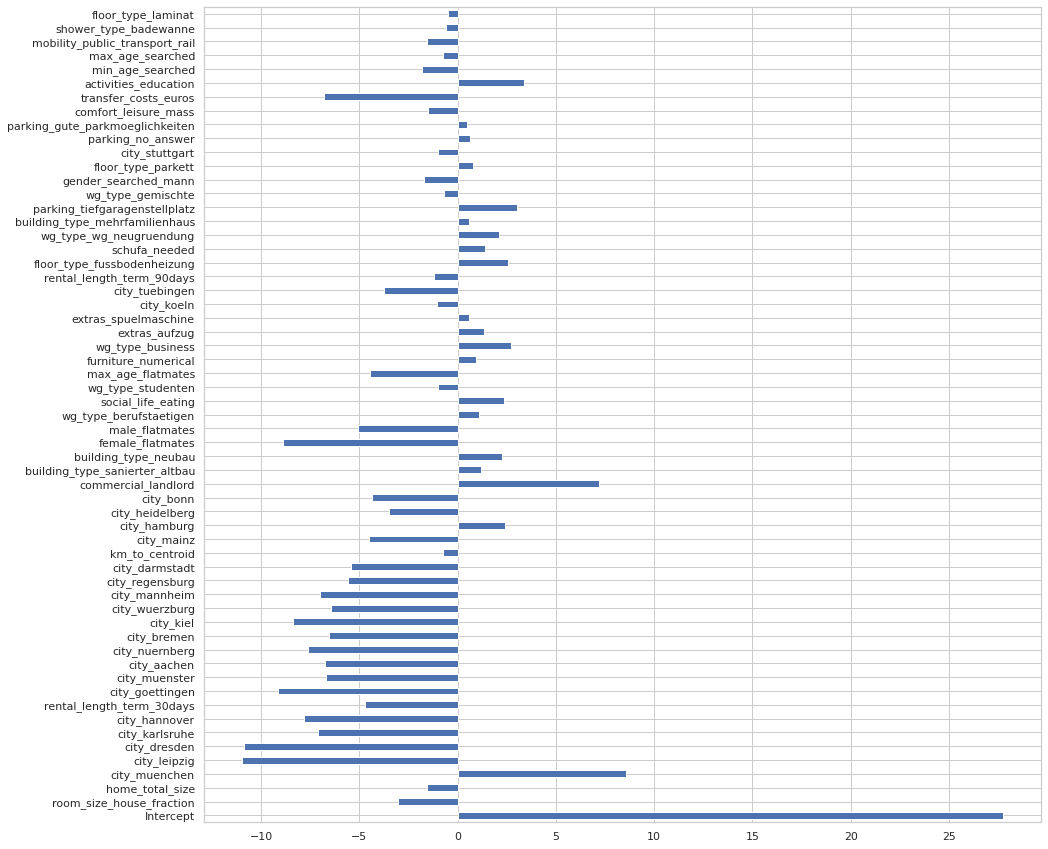

In [60]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model.params[0:].plot(kind='barh');

RMSE: 6.827753821567891
RMSE base model: 9.492324945898975


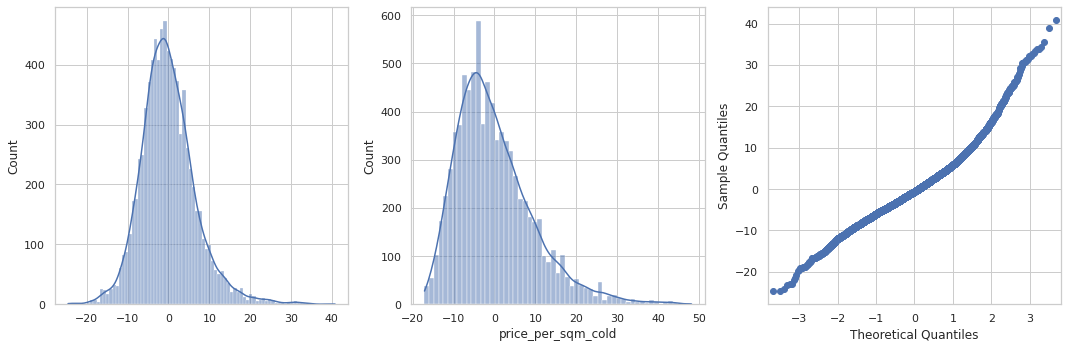

In [61]:
y_pred = model.predict(df_OLS)
y_base = [np.mean(df_OLS['price_per_sqm_cold'])]*len(y_pred)
y_true = df_OLS['price_per_sqm_cold']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_analysed)
residuals = y_true - y_pred 
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model.resid, ax=ax3)
plt.tight_layout()
fig.show();

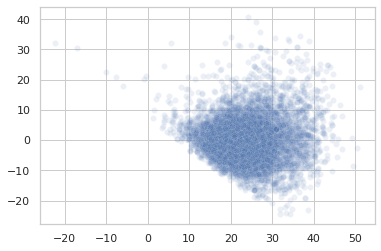

In [62]:
sns.scatterplot(x=model.predict(df_OLS), y=model.resid,alpha=0.1);

                                       p_value       coef
variable                                                 
Intercept                         0.000000e+00  27.769446
city_muenchen                    1.000596e-161   8.567594
commercial_landlord               4.641919e-17   7.188911
activities_education              1.287557e-02   3.368190
parking_tiefgaragenstellplatz     6.334267e-05   3.038769
wg_type_business                  1.277112e-07   2.723897
floor_type_fussbodenheizung       9.436801e-09   2.560160
city_hamburg                      5.027729e-15   2.382986
social_life_eating                2.157808e-05   2.338160
building_type_neubau              1.184020e-10   2.261770
wg_type_wg_neugruendung           8.603932e-06   2.112894
schufa_needed                     2.822886e-07   1.415382
extras_aufzug                     2.811521e-07   1.325670
building_type_sanierter_altbau    5.291378e-09   1.166786
wg_type_berufstaetigen            1.105030e-08   1.061338
furniture_nume

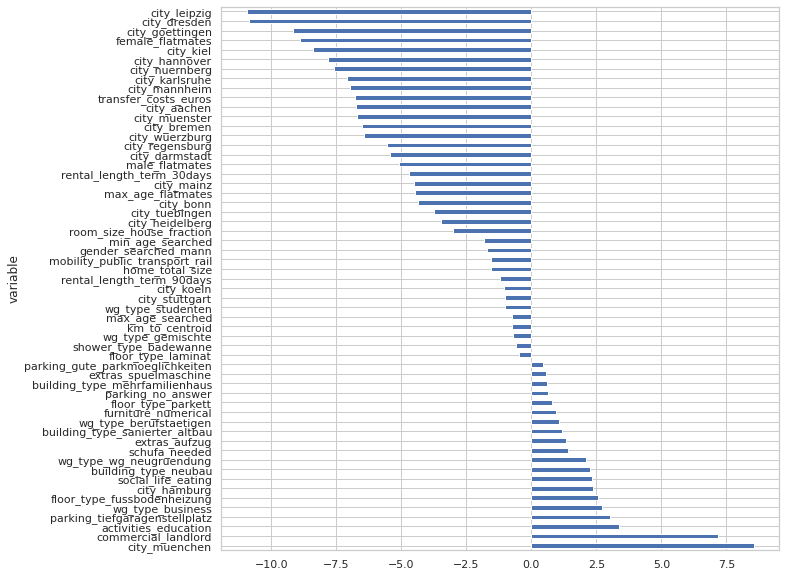

In [63]:
df = return_significative_coef(model).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef[1:].plot(kind='barh');